In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
import math

data = pd.read_csv('train_split.csv')
X, y = data.drop(columns=['Unnamed: 0','Id','SalePrice']), data['SalePrice'].apply(math.log10)

X['CentralAir'] = X['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)
X_train, X_val, y_train, y_val = train_test_split(X, y)

# Add age features
X['HouseAge'] = 2023 - X['YearBuilt']
X['RemodelAge'] = 2023 - X['YearRemodAdd']

# List of categorical columns
categorical_columns = [
    'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
    'Electrical', 'Functional', 'GarageType', 'MiscFeature', 'SaleType',
    'SaleCondition',  'MSSubClass'
]

# List of ordinal columns (ranked data)
ordinal_columns = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
    'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
    'PoolQC', 'Fence', 'CentralAir'
]

# List of numerical columns
numerical_columns = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
    'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold'
]

drop_columns = [
    '1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
    'KitchenAbvGr', 'EnclosedPorch', 'OverallCond', 'MiscVal'
]

X.drop(columns=drop_columns)
## high multicollinearity
# Pair: 1stFlrSF - TotalBsmtSF, Correlation: 0.80
# Pair: TotRmsAbvGrd - GrLivArea, Correlation: 0.83
# Pair: GarageYrBlt - YearBuilt, Correlation: 0.84
# Pair: GarageArea - GarageCars, Correlation: 0.88
# Pair: SalePrice - OverallQual, Correlation: 0.80

## lowest correlation with saleprice
# KitchenAbvGr: -0.14
# EnclosedPorch: -0.11
# OverallCond: -0.08
# MiscVal: -0.04
# YrSold: -0.03
# LowQualFinSF: -0.03
# BsmtHalfBath: -0.02
# BsmtFinSF2: -0.00
# 3SsnPorch: 0.01
# PoolArea: 0.01
# MoSold: 0.05

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder

# Sample ordinal mapping (you can adjust based on the actual dataset)
ordinal_mapping = [
    ('ExterQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('ExterCond', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('BsmtQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('BsmtCond', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('BsmtExposure', ['No', 'Mn', 'Av', 'Gd', 'NaN']),
    ('BsmtFinType1', ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ', 'NaN']),
    ('HeatingQC', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('KitchenQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('FireplaceQu', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('GarageFinish', ['Unf', 'RFn', 'Fin', 'NaN']),
    ('GarageQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('GarageCond', ['Po', 'Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('PavedDrive', ['N', 'P', 'Y', 'NaN']),
    ('PoolQC', ['Fa', 'TA', 'Gd', 'Ex', 'NaN']),
    ('Fence', ['MnWw', 'GdWo', 'MnPrv', 'GdPrv', 'NaN'])
]


# Create an OrdinalEncoder with predefined mapping
ordinal_encoder = OrdinalEncoder(categories=[m[1] for m in ordinal_mapping], handle_unknown='ignore')

# Define pipelines for each type of column
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_pipeline = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[m[1] for m in ordinal_mapping]))
])

numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline(steps=[
    ('label', LabelEncoder())  # CentralAir: Yes/No to 1/0
])

special_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Special case like MSSubClass
])

# Define the column transformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_columns),
    ('ord', ordinal_pipeline, [m[0] for m in ordinal_mapping]),
    ('num', numerical_pipeline, numerical_columns),
    # ('bin', 'passthrough', binary_columns),  # LabelEncoder will be applied separately for binary
])


# Fill NAs

X_train[ordinal_columns] = X_train[ordinal_columns].fillna('NaN')
X_train[categorical_columns] = X_train[categorical_columns].fillna('-1')
X_train[numerical_columns] = X_train[numerical_columns].fillna(X_train[numerical_columns].median())

# Apply transformations
X_preprocessed = preprocessor.fit_transform(X_train)

sample_weights = X_train['OverallQual'] / X_train['OverallQual'].mean()
reg = xgb.XGBRegressor()
# Fit the model, test sets are used for early stopping.
reg.fit(X_preprocessed, y_train, sample_weight=sample_weights)

# Fill NAs for X_val

X_val[ordinal_columns] = X_val[ordinal_columns].fillna('NaN')
X_val[categorical_columns] = X_val[categorical_columns].fillna('-1')
X_val[numerical_columns] = X_val[numerical_columns].fillna(X_train[numerical_columns].median()) # Note that X_val shall be inputed with X_train's mean, since this X_val's own mean is not known on inference time

X_val_preprocessed = preprocessor.transform(X_val)

y_pred = reg.predict(X_val_preprocessed)


from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

## Score

mae = mean_absolute_error(y_val.to_numpy(), y_pred)
mse = mean_squared_error(y_val.to_numpy(), y_pred)
rmse = root_mean_squared_error(y_val.to_numpy(), y_pred)
r2 = r2_score(y_val.to_numpy(), y_pred)

print('ERROR value:', mae, mse, rmse, r2)

### Inference

test_data = pd.read_csv('test_data.csv')

test_data = test_data.drop(columns=['Unnamed: 0','Id'])
test_data['CentralAir'] = test_data['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)

# Fill NAs

test_data[ordinal_columns] = test_data[ordinal_columns].fillna('NaN')
test_data[categorical_columns] = test_data[categorical_columns].fillna('-1')
test_data[numerical_columns] = test_data[numerical_columns].fillna(X_train[numerical_columns].median())

# Apply transformations
X_test_preprocessed = preprocessor.transform(test_data)

y_test_pred = reg.predict(X_test_preprocessed)
y_test_pred = 10**y_test_pred # Correcting the log training

Y_test_pred = pd.DataFrame(y_test_pred, columns=['SalePrice']).reset_index().rename(columns={'index': 'Id'})
Y_test_pred['Id'] = Y_test_pred['Id'] + 1100
Y_test_pred.to_csv('predictions.csv', index=False)

ERROR value: 0.042685527873496304 0.0033532334705920794 0.057907110708375696 0.8666947221033001


               LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
LotFrontage       1.000000  0.388608     0.244318    -0.062296   0.115459   
LotArea           0.388608  1.000000     0.097716     0.002818   0.001278   
OverallQual       0.244318  0.097716     1.000000    -0.082726   0.569303   
OverallCond      -0.062296  0.002818    -0.082726     1.000000  -0.386310   
YearBuilt         0.115459  0.001278     0.569303    -0.386310   1.000000   
YearRemodAdd      0.076640  0.008503     0.560020     0.081385   0.576360   
MasVnrArea        0.190144  0.079456     0.405790    -0.125976   0.316355   
BsmtFinSF1        0.128042  0.188077     0.221694    -0.039508   0.243215   
BsmtFinSF2        0.062113  0.119579    -0.053450     0.040401  -0.045730   
BsmtUnfSF         0.163097 -0.008621     0.323985    -0.134045   0.158145   
TotalBsmtSF       0.326395  0.231469     0.548944    -0.166104   0.399846   
1stFlrSF          0.420916  0.268901     0.471127    -0.159974   0.285317   

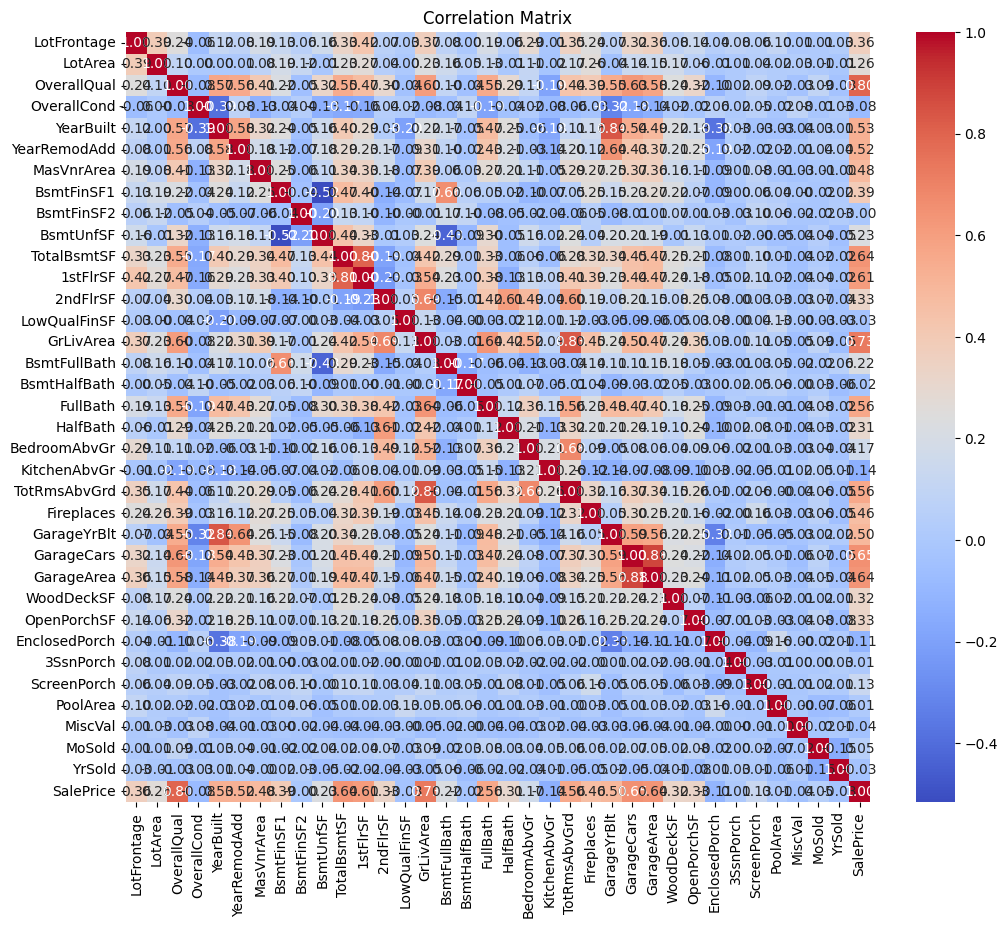

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load your data into a DataFrame
data = pd.read_csv('train_split.csv')
numerical_columns = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
    'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
    'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
    'SalePrice'
]

# Step 2: Calculate the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Step 3: Print the correlation matrix
print(correlation_matrix)

# Step 4 (Optional): Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [3]:
# Find pairs with correlation greater than 0.75
high_corr_pairs = []

# Iterate over the matrix to find pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]
            high_corr_pairs.append((colname_i, colname_j, corr_value))

# Print the pairs
for pair in high_corr_pairs:
    print(f"Pair: {pair[0]} - {pair[1]}, Correlation: {pair[2]:.2f}")

Pair: 1stFlrSF - TotalBsmtSF, Correlation: 0.80
Pair: TotRmsAbvGrd - GrLivArea, Correlation: 0.83
Pair: GarageYrBlt - YearBuilt, Correlation: 0.84
Pair: GarageArea - GarageCars, Correlation: 0.88
Pair: SalePrice - OverallQual, Correlation: 0.80


In [4]:
# Extract and sort the correlation values for 'SalePrice'
saleprice_corr = correlation_matrix['SalePrice'].drop('SalePrice').sort_values()

# Print the sorted correlations
print("Features ordered by correlation with SalePrice (from lowest to highest):")
for feature, corr_value in saleprice_corr.items():
    print(f"{feature}: {corr_value:.2f}")

Features ordered by correlation with SalePrice (from lowest to highest):
KitchenAbvGr: -0.14
EnclosedPorch: -0.11
OverallCond: -0.08
MiscVal: -0.04
YrSold: -0.03
LowQualFinSF: -0.03
BsmtHalfBath: -0.02
BsmtFinSF2: -0.00
3SsnPorch: 0.01
PoolArea: 0.01
MoSold: 0.05
ScreenPorch: 0.13
BedroomAbvGr: 0.17
BsmtFullBath: 0.22
BsmtUnfSF: 0.23
LotArea: 0.26
HalfBath: 0.31
WoodDeckSF: 0.32
OpenPorchSF: 0.33
2ndFlrSF: 0.33
LotFrontage: 0.36
BsmtFinSF1: 0.39
Fireplaces: 0.46
MasVnrArea: 0.48
GarageYrBlt: 0.50
YearRemodAdd: 0.52
YearBuilt: 0.53
TotRmsAbvGrd: 0.56
FullBath: 0.56
1stFlrSF: 0.61
GarageArea: 0.64
TotalBsmtSF: 0.64
GarageCars: 0.65
GrLivArea: 0.73
OverallQual: 0.80


In [7]:
# Retrieve feature importance scores
feature_importances = reg.feature_importances_
print(len(X.columns))
print(len(feature_importances))

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importance scores
print(importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()

81
227


ValueError: All arrays must be of the same length